# EF4821 Project

## Fundamental setting and library loading

In [22]:
# analysis-related libraries
!pip install quandl
!pip install QuantLib
from QuantLib import *
import quandl
quandl.ApiConfig.api_key = "sAyfjP-zzwW8eWktkXq3" 

# fundamental libraries
import matplotlib.pyplot as plt
import numpy as np
from math import *
from scipy.stats import *
import pandas as pd
from mpl_toolkits.mplot3d.axes3d import Axes3D
from collections import namedtuple
from matplotlib.colors import LinearSegmentedColormap

# preliminary setting
%config IPCompleter.greedy = True
cmap = LinearSegmentedColormap.from_list('mycmap', ['#0160BF', 'white', '#0160BF'])
x , y = np.meshgrid(list(range(1, 11)), list(range(1, 11)))

## Data

In [23]:
# Instaneous forward rate extracted from quandl
rates = [0.1332, 0.2679, 0.4679, 0.6824, 0.8859, 1.0675, 1.2241, 1.3569, 1.469, 1.5641, 1.6456, 1.7167, 1.78, 
       1.8374, 1.8907, 1.9408, 1.9887, 2.0349, 2.0797, 2.1234, 2.166, 2.2077, 2.2483, 2.288, 2.3265, 2.364, 
       2.4003, 2.4354, 2.4692, 2.5017]
rates = [i*0.01 for i in rates]
print(rates)

[0.001332, 0.0026790000000000004, 0.004679, 0.006824, 0.008859, 0.010674999999999999, 0.012241, 0.013569, 0.014690000000000002, 0.015641000000000002, 0.016456, 0.017166999999999998, 0.0178, 0.018373999999999998, 0.018907, 0.019408, 0.019887, 0.020349, 0.020797, 0.021234000000000003, 0.02166, 0.022077, 0.022483, 0.022879999999999998, 0.023264999999999997, 0.023639999999999998, 0.024003, 0.024354, 0.024692, 0.025017]


In [24]:
# Quoted swaption volatilities
df = pd.read_excel('/content/drive/MyDrive/CityU Study/Yr4 Sem A/EF4821/Project/swaption volatility.xlsx')
df = df.set_index('Expiry')
df.set_axis([i for i in range(1, 11)], axis=1, inplace=True)
df.set_axis([i for i in range(1, 11)], axis=0, inplace=True)
vol = df.values.tolist()
for i in range(0, 10):
  for k in range(0, 10):
    vol[i][k]*=0.01
vol = np.reshape(vol, (10,10))
vol

array([[0.5555, 0.6186, 0.6605, 0.6938, 0.6781, 0.6676, 0.6121, 0.6238,
        0.5978, 0.5889],
       [0.6502, 0.6745, 0.66  , 0.6324, 0.6192, 0.6088, 0.5646, 0.5757,
        0.5651, 0.5353],
       [0.7083, 0.6462, 0.6432, 0.5845, 0.572 , 0.5509, 0.5457, 0.5252,
        0.516 , 0.5048],
       [0.6435, 0.5665, 0.5491, 0.5448, 0.5163, 0.5084, 0.4881, 0.4878,
        0.4833, 0.4736],
       [0.5626, 0.5273, 0.5063, 0.4973, 0.4742, 0.4776, 0.4559, 0.4619,
        0.4586, 0.447 ],
       [0.5308, 0.5008, 0.42  , 0.4597, 0.4515, 0.4586, 0.4441, 0.4149,
        0.4442, 0.408 ],
       [0.5048, 0.4664, 0.4457, 0.4312, 0.4159, 0.4423, 0.4158, 0.43  ,
        0.428 , 0.4289],
       [0.4675, 0.4413, 0.4428, 0.4225, 0.423 , 0.385 , 0.3842, 0.3833,
        0.4164, 0.4151],
       [0.4419, 0.4112, 0.4239, 0.4164, 0.3817, 0.4212, 0.38  , 0.412 ,
        0.4116, 0.412 ],
       [0.4262, 0.4311, 0.3823, 0.3349, 0.3932, 0.4152, 0.3431, 0.4129,
        0.4126, 0.4023]])

## Calibration

### Setting

In [25]:
# setting calibration method and criteria
optimization_method = LevenbergMarquardt(1.0e-8,1.0e-8,1.0e-8)
end_criteria = EndCriteria(100000, 100, 1e-8, 1e-8, 1e-8)

In [26]:
# building term structure and setting reference index
dates = []
for i in range(len(rates)):
  dates.append(Date(20, 11, int("20"+str((i+21)))))
today = Date(20, 11, 2020)
Settings.instance().evaluationDate = today
term_structure = YieldTermStructureHandle(
    ForwardCurve(dates,rates,Actual365Fixed())
    )
index = USDLibor(Period(6, Months), term_structure)

In [27]:
# create a series of calibration data
CalibrationData = namedtuple("CalibrationData", "start, length, volatility")
data = []
for i in range(len(vol)):
  for j in range(len(vol[0])):
    data.append(CalibrationData(i+1, j+1, vol[i][j]))

In [28]:
# model calibration
def calibration_report(swaptions, data):
    print ("-"*100)
    print ("%15s %15s %15s %15s %15s %15s" % ("Model Price", "Market Price", "Implied Vol", "Market Vol", "Price Error", "Vol Diff"))
    print ("-"*100)
    sum_error1 = 0.0
    sum_error2 = 0.0
    for i, s in enumerate(swaptions):
        model_price = s.modelValue()
        market_vol = data[i].volatility
        black_price = s.blackPrice(market_vol)
        error = black_price-model_price
        sum_error1+=error*error
        implied_vol = s.impliedVolatility(model_price, 1e-5, 100, 0.0, 4.0)
        error2 = market_vol-implied_vol
        sum_error2+=error2*error2

        model_p.append(model_price)
        market_v.append(market_vol)
        black_p.append(black_price)
        implied_v.append(implied_vol)
        price_d_p.append(((model_price-black_price)/black_price)*100)

        print ("%15.5f %15.5f %15.5f %15.5f %15.5f %15.5f" % (model_price, black_price, implied_vol, market_vol, error, error2))
    print ("-"*100)
    print ("Sum Error Price      : %15.5f" % sum_error1)
    print ("Sum Error Volatility : %15.5f" % sum_error2)

### Black-Karasinski model

In [29]:
# swaption pricing
def create_swaption_helpers(data, index, term_structure, engine):
    swaptions = []
    fixed_leg_daycounter = Actual360()
    floating_leg_daycounter = Actual360()
    for d in data:
        vol_handle = QuoteHandle(SimpleQuote(d.volatility))
        helper = SwaptionHelper(Period(d.start, Years),
                                   Period(d.length, Years),
                                   vol_handle,
                                   index,
                                   Period(d.length, Years),
                                   fixed_leg_daycounter,
                                   floating_leg_daycounter,
                                   term_structure,
                                   )
        helper.setPricingEngine(engine)
        swaptions.append(helper)
    return swaptions    

In [30]:
# model calibration
model = BlackKarasinski(term_structure)
engine = TreeSwaptionEngine(model, 100)
swaptions = create_swaption_helpers(data, index, term_structure, engine)

model.calibrate(swaptions, optimization_method, end_criteria)

# best-fit parameter extraction
a, sigma =  model.params()
print ("a = %6.5f, sigma = %6.5f" % (a, sigma))

a = 0.04509, sigma = 0.80301


In [31]:
# result presentation
model_p = []
market_v = []
black_p = []
implied_v = []
price_d_p=[]

calibration_report(swaptions, data)

----------------------------------------------------------------------------------------------------
    Model Price    Market Price     Implied Vol      Market Vol     Price Error        Vol Diff
----------------------------------------------------------------------------------------------------
        0.00140         0.00143         0.54496         0.55550         0.00003         0.01054
        0.00335         0.00389         0.52784         0.61860         0.00054         0.09076
        0.00565         0.00727         0.50617         0.66050         0.00162         0.15433
        0.00829         0.01150         0.49015         0.69380         0.00322         0.20365
        0.01106         0.01560         0.47125         0.67810         0.00455         0.20685
        0.01383         0.02007         0.45114         0.66760         0.00624         0.21646
        0.01650         0.02312         0.43013         0.61210         0.00662         0.18197
        0.01905         0.0284

In [32]:
# reshape the result variables for plotting
model_p = np.reshape(model_p, (10,10))
market_v = np.reshape(market_v, (10, 10))
black_p = np.reshape(black_p, (10, 10))
implied_v = np.reshape(implied_v, (10, 10))
price_d_p = np.reshape(price_d_p, (10, 10))

#### Result plot

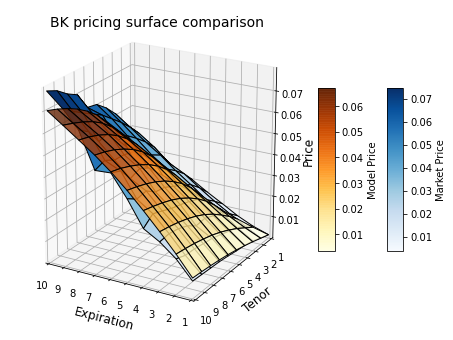

In [33]:
# price
fig = plt.figure(figsize=(8, 6))
ax = plt.axes(projection='3d')
ax.set_xlim(1, 10, 1)
ax.set_ylim(1, 10, 1)

surf = ax.plot_surface(x, y, black_p, rstride=1, cstride=1,
                cmap='Blues', edgecolor='k')
cbar = fig.colorbar(surf, shrink=0.5, aspect=10, pad=0.03)
cbar.set_label('Market Price')
surf = ax.plot_surface(x, y, model_p, rstride=1, cstride=1,
                cmap='YlOrBr', edgecolor='k', alpha=0.8)
cbar = fig.colorbar(surf, shrink=0.5, aspect=10, pad=0.03)
cbar.set_label('Model Price')

ax.set_title('BK pricing surface comparison', fontsize=14)
ax.set_xlabel('Expiration',fontsize=12)
ax.set_ylabel('Tenor',fontsize=12)
ax.set_zlabel('Price',fontsize=12)

elev = 20
azim = 120
ax.view_init(elev, azim)

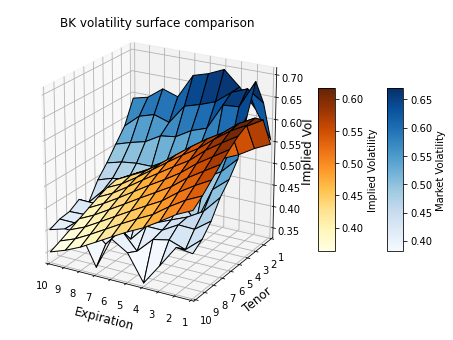

In [34]:
# volatility
fig = plt.figure(figsize=(8, 6))
ax = plt.axes(projection='3d')
ax.set_xlim(1, 10, 1)
ax.set_ylim(1, 10, 1)

surf1 = ax.plot_surface(x, y, market_v, rstride=1, cstride=1,
                cmap='Blues', edgecolor='k')
cbar = fig.colorbar(surf1, shrink=0.5, aspect=10, pad=0.03)
cbar.set_label('Market Volatility')
surf2 = ax.plot_surface(x, y, implied_v, rstride=1, cstride=1,
                cmap='YlOrBr', edgecolor='k')
cbar = fig.colorbar(surf2, shrink=0.5, aspect=10, pad=0.03)
cbar.set_label('Implied Volatility')

ax.set_title('BK volatility surface comparison')
ax.set_xlabel('Expiration',fontsize=12)
ax.set_ylabel('Tenor',fontsize=12)
ax.set_zlabel('Implied Vol',fontsize=12)

elev = 20
azim = 120
ax.view_init(elev, azim)

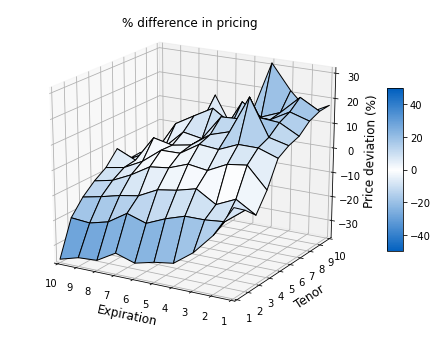

In [35]:
# % difference in pricing
fig = plt.figure(figsize=(8, 6))
ax = plt.axes(projection='3d')
ax.set_xlim(1, 10, 1)
ax.set_ylim(10, 1, -1)

surf = ax.plot_surface(x, y, price_d_p, rstride=1, cstride=1,
                cmap=cmap, edgecolor='k', vmin=-50, vmax=50)
fig.colorbar(surf, shrink=0.5, aspect=10, pad=0.03)

ax.set_title('% difference in pricing')
ax.set_xlabel('Expiration',fontsize=12)
ax.set_ylabel('Tenor',fontsize=12)
ax.set_zlabel('Price deviation (%)',fontsize=12)

elev = 20
azim = 120
ax.view_init(elev, azim)

### Hull-White 1-Factor model

In [36]:
# swaption pricing
def create_swaption_helpers(data, index, term_structure, engine):
    swaptions = []
    fixed_leg_daycounter = Actual360()
    floating_leg_daycounter = Actual360()
    for d in data:
        vol_handle = QuoteHandle(SimpleQuote(d.volatility))
        helper = SwaptionHelper(Period(d.start, Years),
                                   Period(d.length, Years),
                                   vol_handle,
                                   index,
                                   Period(d.length, Years),
                                   fixed_leg_daycounter,
                                   floating_leg_daycounter,
                                   term_structure,
                                    Normal
                                   )
        helper.setPricingEngine(engine)
        swaptions.append(helper)
    return swaptions    

In [37]:
# model calibration
model = HullWhite(term_structure)
engine = FdHullWhiteSwaptionEngine(model)
swaptions = create_swaption_helpers(data, index, term_structure, engine)

model.calibrate(swaptions, optimization_method, end_criteria)

# best-fit parameter extraction
a, sigma = model.params()
print ("a = %6.5f, sigma = %6.5f" % (a, sigma))

a = 0.01145, sigma = 0.00763


In [38]:
# result presentation
model_p = []
market_v = []
black_p = []
implied_v = []
price_d_p=[]

calibration_report(swaptions, data)

----------------------------------------------------------------------------------------------------
    Model Price    Market Price     Implied Vol      Market Vol     Price Error        Vol Diff
----------------------------------------------------------------------------------------------------
        0.00300         0.00143         1.30130         0.55550        -0.00158        -0.74580
        0.00600         0.00389         1.00103         0.61860        -0.00210        -0.38243
        0.00893         0.00727         0.82773         0.66050        -0.00166        -0.16723
        0.01182         0.01150         0.71446         0.69380        -0.00031        -0.02066
        0.01469         0.01560         0.63545         0.67810         0.00091         0.04265
        0.01753         0.02007         0.57787         0.66760         0.00254         0.08973
        0.02034         0.02312         0.53462         0.61210         0.00278         0.07748
        0.02312         0.0284

In [39]:
# reshape result variables for plotting
model_p = np.reshape(model_p, (10,10))
market_v = np.reshape(market_v, (10, 10))
black_p = np.reshape(black_p, (10, 10))
implied_v = np.reshape(implied_v, (10, 10))
price_d_p = np.reshape(price_d_p, (10, 10))

#### Result plot

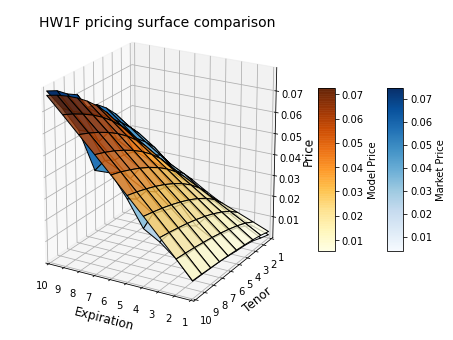

In [40]:
# Price
fig = plt.figure(figsize=(8, 6))
ax = plt.axes(projection='3d')
ax.set_xlim(1, 10, 1)
ax.set_ylim(1, 10, 1)

surf1 = ax.plot_surface(x, y, black_p, rstride=1, cstride=1,
                cmap='Blues', edgecolor='k')
cbar = fig.colorbar(surf1, shrink=0.5, aspect=10, pad=0.03)
cbar.set_label('Market Price')
surf2 = ax.plot_surface(x, y, model_p, rstride=1, cstride=1,
                cmap='YlOrBr', edgecolor='k', alpha=0.8)
cbar = fig.colorbar(surf2, shrink=0.5, aspect=10, pad=0.03)
cbar.set_label('Model Price')

ax.set_title('HW1F pricing surface comparison',fontsize=14)
ax.set_xlabel('Expiration',fontsize=12)
ax.set_ylabel('Tenor',fontsize=12)
ax.set_zlabel('Price',fontsize=12)

elev = 20
azim = 120
ax.view_init(elev, azim)

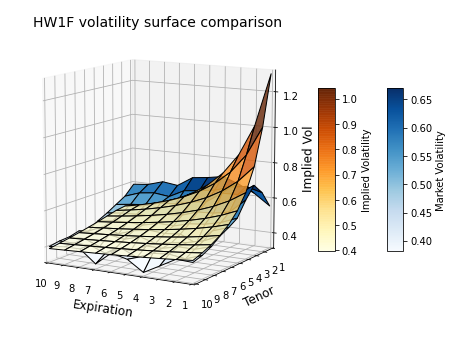

In [41]:
# volatility
fig = plt.figure(figsize=(8, 6))
ax = plt.axes(projection='3d')
ax.set_xlim(1, 10, 1)
ax.set_ylim(1, 10, 1)

surf1 = ax.plot_surface(x, y, market_v, rstride=1, cstride=1,
                cmap='Blues', edgecolor='k')
cbar = fig.colorbar(surf1, shrink=0.5, aspect=10, pad=0.03)
cbar.set_label('Market Volatility')
surf2 = ax.plot_surface(x, y, implied_v, rstride=1, cstride=1,
                cmap='YlOrBr', edgecolor='k', alpha=0.8)
cbar = fig.colorbar(surf2, shrink=0.5, aspect=10, pad=0.03)
cbar.set_label('Implied Volatility')

ax.set_title('HW1F volatility surface comparison',fontsize=14)
ax.set_xlabel('Expiration',fontsize=12)
ax.set_ylabel('Tenor',fontsize=12)
ax.set_zlabel('Implied Vol',fontsize=12)

elev = 10
azim = 120
ax.view_init(elev, azim)

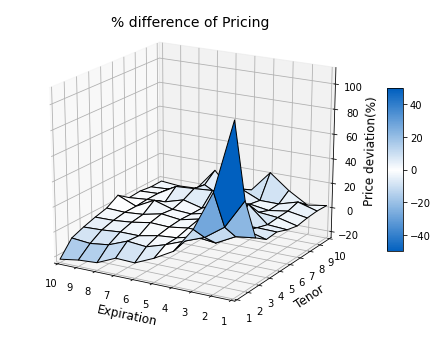

In [42]:
# percentage difference of price
fig = plt.figure(figsize=(8, 6))
ax = plt.axes(projection='3d')
ax.set_xlim(1, 10, 1)
ax.set_ylim(10, 1, -1)

surf = ax.plot_surface(x, y, price_d_p, rstride=1, cstride=1,
                cmap=cmap, edgecolor='k', vmin=-50, vmax=50)
fig.colorbar(surf, shrink=0.5, aspect=10, pad=0.03)

ax.set_title('% difference of Pricing', fontsize=14)
ax.set_xlabel('Expiration',fontsize=12)
ax.set_ylabel('Tenor',fontsize=12)
ax.set_zlabel('Price deviation(%)',fontsize=12)

elev = 20
azim = 120
ax.view_init(elev, azim)